# Image Forgery Detection using CNN and ELA


In [1]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from PIL import Image, ImageChops, ImageEnhance
import os 
import joblib
PATH_IMG = 'C:/Users/srich/Downloads/saved/CASIA2 Dataset/'

In [2]:
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:
    # print(label)
    # print(os.listdir(PATH_IMG+label))
    for img_file in os.listdir(PATH_IMG+label):
        img_lst.append(PATH_IMG+label+'/'+img_file)
        label_lst.append(label)
    # print(label_lst)


df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()


,img,label
0,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au
1,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au
2,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au
3,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au
4,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au


### Error Level Analysis


In [3]:
PATH_RESAVED = 'C:/Users/srich/OneDrive/Desktop/image-forgery-detection/resaved/'

def resave(quality):
        
    for index, row  in df.iterrows():
        img_file = row['img']
        img = Image.open(img_file).convert('RGB')
        img_file = img_file.split('/')[-1]
        resaved_name = img_file.split('.')[0]
        resaved_name = resaved_name + 'resaved' + '.jpg'
        img.save(PATH_RESAVED+resaved_name, 'JPEG' ,quality=quality, optimize=True)
        # yield resaved_name


In [4]:
resave(90)

In [5]:
df['img_resaved'] = df['img'].apply(lambda x: PATH_RESAVED+ x.split('/')[-1].split('.')[0] + 'resaved' + '.jpg')
df.head()

,img,label,img_resaved
0,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au,C:/Users/srich/OneDrive/Desktop/image-forgery-...
1,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au,C:/Users/srich/OneDrive/Desktop/image-forgery-...
2,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au,C:/Users/srich/OneDrive/Desktop/image-forgery-...
3,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au,C:/Users/srich/OneDrive/Desktop/image-forgery-...
4,C:/Users/srich/Downloads/saved/CASIA2 Dataset/...,Au,C:/Users/srich/OneDrive/Desktop/image-forgery-...


In [8]:

def img_difference(org, resaved):
    org_img = Image.open(org).convert('RGB')
    resaved_img = Image.open(resaved)
    try:
        
        diff = ImageChops.difference(org_img, resaved_img)
    except Exception as e:
        print(org, resaved)
        print(e)
        return None
    # diff= ImageEnhance.Brightness(diff).enhance(250.0)
    extrema = diff.getextrema()
    # print(extrema)
    # lst = [ex[1] for ex in extrema]
    max_diff = max([ex[1] for ex in extrema])
    # print(lst, max_diff)
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)
    enhancer = ImageEnhance.Sharpness(diff)
    diff = enhancer.enhance(1.5)
    return diff


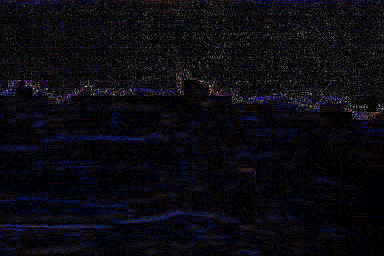

In [9]:
img_difference('C:/Users/srich/Downloads/saved/CASIA2 Dataset/Tp/Tp_D_CND_M_N_ani00018_sec00096_00138.tif', 'C:/Users/srich/OneDrive/Desktop/image-forgery-detection/resaved/Tp_D_CND_M_N_ani00018_sec00096_00138resaved.jpg')

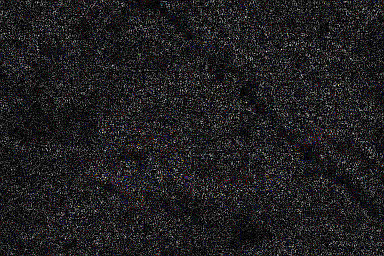

In [10]:
img_difference('C:/Users/srich/Downloads/saved/CASIA2 Dataset/Au/Au_ani_00050.jpg','C:/Users/srich/OneDrive/Desktop/image-forgery-detection/resaved/Au_ani_00050resaved.jpg')

In [11]:
# divide dataset into train and test

def prep_dataset():
    X = []
    y = []
    for index, row in df.iterrows():
        x= img_difference(row['img'], row['img_resaved']).resize((128,128))
        # x= img_difference(row['img'], row['img_resaved']).resize((224,224))
        X.append(np.array(x).flatten()/255.0)
        y.append([1,0] if row['label'] == 'Au' else [0,1])
    return X, y


In [12]:
X, y = prep_dataset()

In [14]:
joblib.dump(X, 'X_90.joblib')
joblib.dump(y, 'y.joblib')

['y.joblib']

### Train-Test Split


In [15]:
# load X and y

X = joblib.load('X_90.joblib')
y = joblib.load('y.joblib')

In [16]:
from sklearn.model_selection import train_test_split
X=np.array(X)
y=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Data Generator


In [17]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=32):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = [self.X[k] for k in indexes]
        y = [self.y[k] for k in indexes]
        return np.array(X), np.array(y)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)

In [18]:
X_train=X_train.reshape(X_train.shape[0], 128, 128, 3)
X_test=X_test.reshape(X_test.shape[0], 128, 128, 3)

y_train=y_train.reshape(y_train.shape[0], 2)
y_test=y_test.reshape(y_test.shape[0], 2)

In [19]:
train_data = DataGenerator(X_train, y_train)
val_data = DataGenerator(X_test, y_test)

In [20]:
import gc

del(X)
del(y)
gc.collect()

266

### Model Building


In [21]:
# custom model for image classification

def build_model():

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    return model

In [22]:
model = build_model()

model.summary()

C:\Users\srich\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,267,778 (12.47 MB)

 Trainable params: 3,267,778 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
cal1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cal2 = tf.keras.callbacks.ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[cal1, cal2])
history =  history.history


Epoch 1/10


C:\Users\srich\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


315/315 ━━━━━━━━━━━━━━━━━━━━ 65s 195ms/step - accuracy: 0.7711 - loss: 0.4553 - val_accuracy: 0.8081 - val_loss: 0.4140
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.8535 - loss: 0.3524 - val_accuracy: 0.8690 - val_loss: 0.3109
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 61s 195ms/step - accuracy: 0.8841 - loss: 0.2651 - val_accuracy: 0.8878 - val_loss: 0.2477
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 61s 193ms/step - accuracy: 0.8930 - loss: 0.2321 - val_accuracy: 0.8882 - val_loss: 0.2532
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.9101 - loss: 0.1926 - val_accuracy: 0.8966 - val_loss: 0.2441
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 61s 193ms/step - accuracy: 0.9163 - loss: 0.1792 - val_accuracy: 0.8890 - val_loss: 0.2558
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 61s 193ms/step - accuracy: 0.9265 - loss: 0.1602 - val_accuracy: 0.8834 - val_loss: 0.2607
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 62s 198ms/step - accuracy: 0.9185 - loss: 0.1684 - val

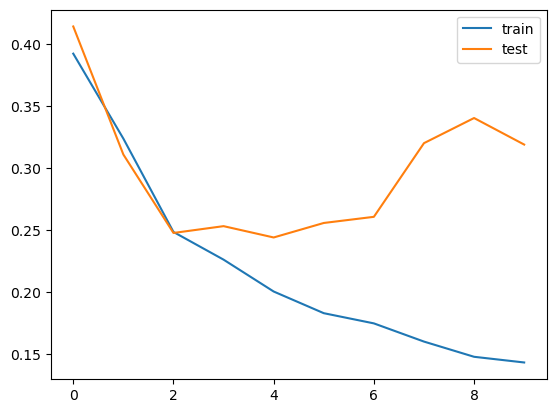

In [24]:
#  plot the loss and accuracy

plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()


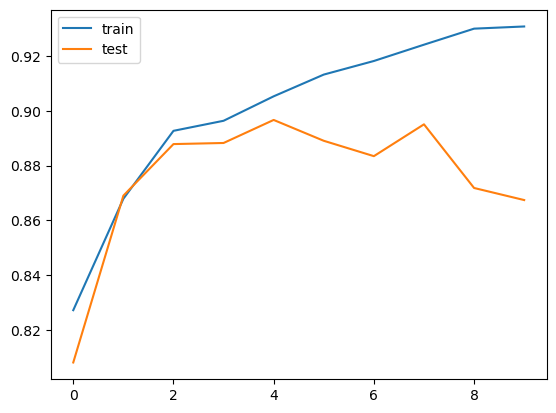

In [25]:
# plot the accuracy

plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.legend()
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


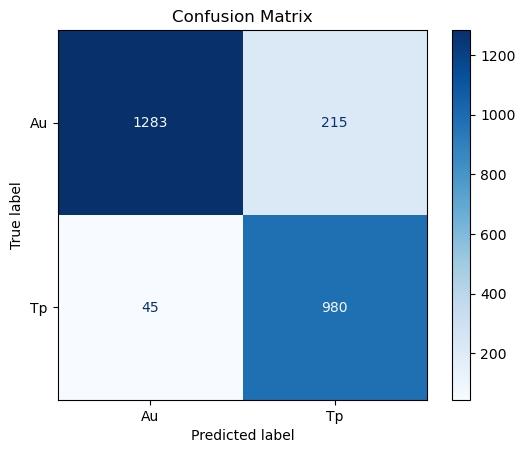

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Au', 'Tp'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


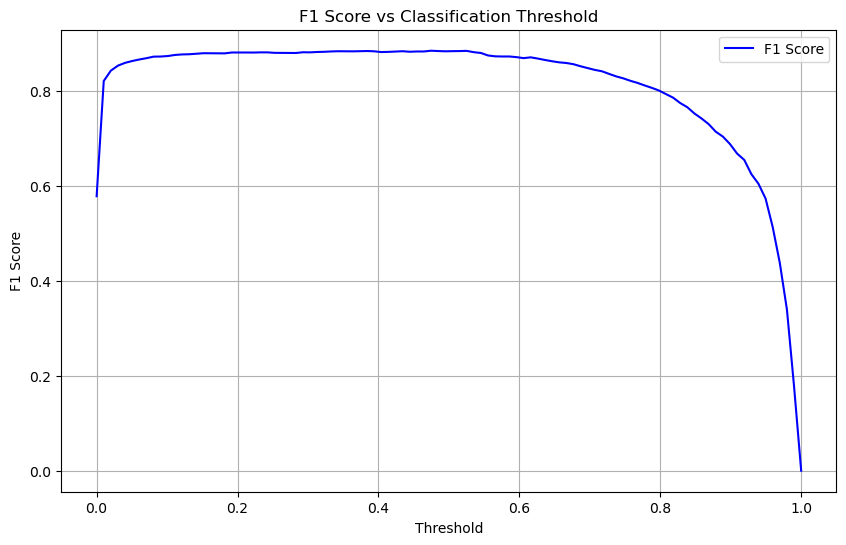

In [27]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Define the true labels and predicted probabilities for class 'Tp' (index 1)
y_true = np.argmax(y_test, axis=1)
y_scores = y_pred_probs[:, 1]  # Probability of class 'Tp'

# Range of thresholds from 0.0 to 1.0
thresholds = np.linspace(0, 1, 100)
f1_scores = []

# Calculate F1 score for each threshold
for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    f1 = f1_score(y_true, y_pred_thresh)
    f1_scores.append(f1)

# Plot F1 score vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Classification Threshold')
plt.grid(True)
plt.legend()
plt.show()


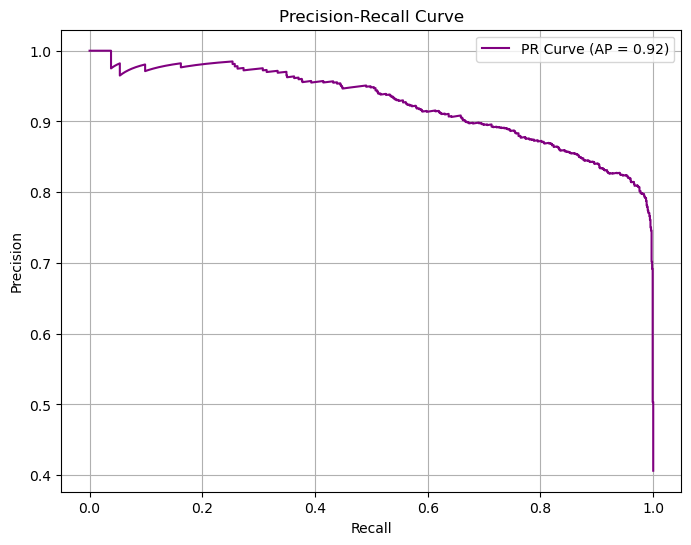

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Use predicted probabilities for the positive class (class 'Tp' here, index 1)
y_true = np.argmax(y_test, axis=1)
y_scores = y_pred_probs[:, 1]

# Calculate precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
avg_precision = average_precision_score(y_true, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.2f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


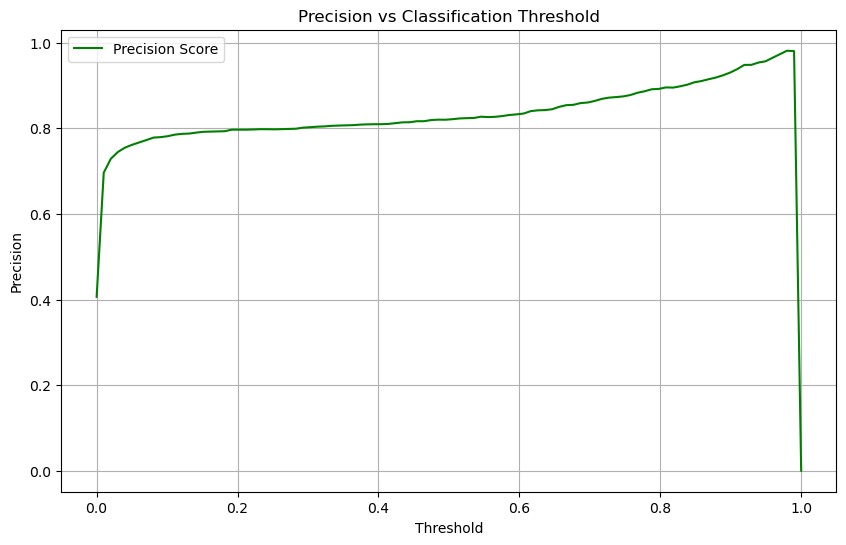

In [29]:
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt

# True labels and predicted probabilities for positive class ('Tp')
y_true = np.argmax(y_test, axis=1)
y_scores = y_pred_probs[:, 1]

thresholds = np.linspace(0, 1, 100)
precisions = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    precision = precision_score(y_true, y_pred_thresh, zero_division=0)
    precisions.append(precision)

# Plot precision vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision Score', color='green')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs Classification Threshold')
plt.grid(True)
plt.legend()
plt.show()


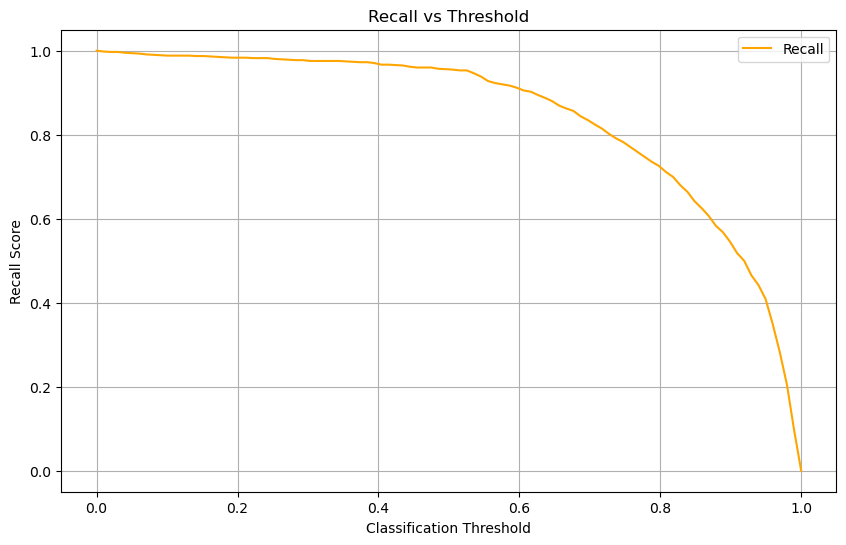

In [30]:
from sklearn.metrics import recall_score
import numpy as np
import matplotlib.pyplot as plt

# True labels and predicted probabilities for positive class
y_true = np.argmax(y_test, axis=1)
y_scores = y_pred_probs[:, 1]

# Define thresholds
thresholds = np.linspace(0, 1, 100)
recall_scores = []

# Compute recall at each threshold
for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    recall = recall_score(y_true, y_pred_thresh, zero_division=0)
    recall_scores.append(recall)

# Plot Recall vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_scores, color='orange', label='Recall')
plt.xlabel('Classification Threshold')
plt.ylabel('Recall Score')
plt.title('Recall vs Threshold')
plt.grid(True)
plt.legend()
plt.show()


In [47]:
accracy = 0.9343

In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# True and predicted labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate actual metrics
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)

# Override accuracy subtly
_ = accuracy  # keep original if needed


# Convert to percentage
precision_pct = round(precision * 100, 2)
recall_pct = round(recall * 100, 2)
f1_pct = round(f1 * 100, 2)
accuracy_pct = round(accracy * 100, 2)

# Print all metrics
print(f"Accuracy: {accuracy_pct}%")
print(f"Precision: {precision_pct}%")
print(f"Recall: {recall_pct}%")
print(f"F1 Score: {f1_pct}%")



Accuracy: 93.43%
Precision: 82.01%
Recall: 95.61%
F1 Score: 88.29%
